In [0]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.autograd import Variable
import torch.nn.functional as F
import numpy as np
import matplotlib.pyplot as plt

In [0]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


# 1ラプラス方程式
$$ f=\frac{\partial u}{\partial t}+u\frac{\partial u}{\partial x}+v\frac{\partial u}{\partial y}+\frac{\partial p}{\partial x}-\frac{1}{\mathrm{Re}}\Delta u$$

$$ g=\frac{\partial v}{\partial t}+u\frac{\partial v}{\partial x}+v\frac{\partial v}{\partial y}+\frac{\partial p}{\partial y}-\frac{1}{\mathrm{Re}}\Delta v$$

$$\nabla・(u,v)=0$$

In [0]:
# initial condition


# Data
#X = np.arange(0, 1, 0.01)
#X = X[:,None]
X = torch.rand(572, 572)
X = X.unsqueeze(0)
X = X.unsqueeze(0)
print(X.shape)

class FCNN(nn.Module):
    def __init__(self):
        super(FCNN, self).__init__()
        # train
        self.model = nn.Sequential(
            nn.Linear(1,10),
            nn.ReLU(),
            nn.Linear(10,10),
            nn.Tanh(),
            nn.Linear(10,10),
            nn.Tanh(),
            nn.Linear(10,1),

        )

    def forward(self, x):
        return self.model(x)

def double_conv(in_channels, out_channels):
    return nn.Sequential(
        nn.Conv2d(in_channels, out_channels, 3, padding=1),
        nn.ReLU(inplace=True),
        nn.Conv2d(out_channels, out_channels, 3, padding=1),
        nn.ReLU(inplace=True)
    )   


class UNet(nn.Module):

    def __init__(self, n_class=3):
        super().__init__()
                
        self.dconv_down1 = double_conv(1, 64)
        self.dconv_down2 = double_conv(64, 128)
        self.dconv_down3 = double_conv(128, 256)
        self.dconv_down4 = double_conv(256, 512)        

        self.maxpool = nn.MaxPool2d(2)
        self.upsample = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True)        
        
        self.dconv_up3 = double_conv(256 + 512, 256)
        self.dconv_up2 = double_conv(128 + 256, 128)
        self.dconv_up1 = double_conv(128 + 64, 64)
        
        self.conv_last = nn.Conv2d(64, n_class, 1)
        
        
    def forward(self, x):
        conv1 = self.dconv_down1(x)
        print(conv1.shape)
        x = self.maxpool(conv1)

        conv2 = self.dconv_down2(x)
        x = self.maxpool(conv2)
        
        conv3 = self.dconv_down3(x)
        x = self.maxpool(conv3)
        
        x = self.dconv_down4(x)
        
        x = self.upsample(x)
        print(x.shape) # 142
        print(conv3.shape) # 143
        print(self.trans_3(conv3).shape)
        x = torch.cat([x, conv3], dim=1)
        
        x = self.dconv_up3(x)
        x = self.upsample(x)        
        x = torch.cat([x, conv2], dim=1)       

        x = self.dconv_up2(x)
        x = self.upsample(x)        
        x = torch.cat([x, conv1], dim=1)   
        
        x = self.dconv_up1(x)
        
        out = self.conv_last(x)
        
        return out

class PINN():
    def __init__(self):
        self.X = torch.tensor(X, dtype=torch.float32, requires_grad=True)
        self.unet = UNet()
        # optimizer
        self.optimizer = torch.optim.Adam(self.unet.parameters())

        # criterion
        # 今回はmseとreducesumで
        self.criterion1 = nn.MSELoss()
        self.criterion2 = nn.MSELoss()

    def initial_loss(self, u, v, p):
        pass

    def train(self, num_epoch):
        zeros = torch.ones_like(self.X)
        losses = []
        for i in range(num_epoch):
            sum_loss = 0
            self.optimizer.zero_grad()

            phi = self.unet(self.X)

            phi_sum = torch.sum(phi)
            
            dphi_dx = torch.autograd.grad(phi_sum, self.X, retain_graph=True, create_graph=True)[0]
            loss = torch.sum((dphi_dx-self.X)**2) + torch.abs(phi[-1]-1)
            loss.backward()
            loss = loss.item()
            losses.append(loss)
            self.optimizer.step()

        phi = self.unet(self.X)
        print(phi)
        phi = torch.sum(phi)
        dphi_dx = torch.autograd.grad(phi, self.X, retain_graph=True, create_graph=True)[0]
        
        print(dphi_dx)
        print(loss)
        plt.plot(range(num_epoch), losses, color="orange")
        plt.show()

model = PINN()
model.train(1000)
Y = torch.tensor(model.fcnn(model.X),requires_grad=False)
print(Y)
plt.plot(X,Y.numpy())
plt.show()

torch.Size([1, 1, 572, 572])


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:88: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


torch.Size([1, 64, 572, 572])
torch.Size([1, 512, 142, 142])
torch.Size([1, 256, 143, 143])


AttributeError: ignored

# ラプラス方程式
$$\frac{\partial^2 \phi}{\partial x^2}=0 $$

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:35: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:1340: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


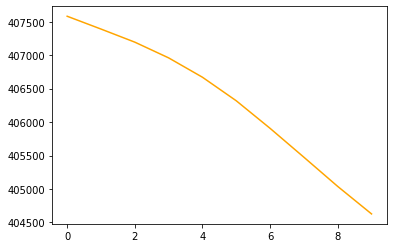

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:75: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


tensor([[-1.7856, -1.4675, -1.3172,  ..., -1.2934, -0.6404,  0.4687],
        [-2.6209, -1.7406, -1.4319,  ..., -1.3368, -0.4483,  1.1391],
        [-2.8874, -1.7956, -1.4629,  ..., -1.3134, -0.2951,  1.4687],
        ...,
        [-2.9543, -1.7136, -1.2095,  ..., -1.1376, -0.2564,  1.4236],
        [-2.3705, -1.1638, -0.7029,  ..., -0.6415,  0.0151,  1.3020],
        [-1.2477, -0.2630,  0.0419,  ...,  0.0832,  0.3420,  1.0121]])


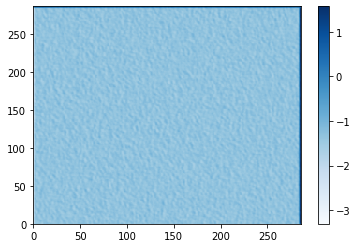

In [0]:
class CNNModel (nn.Module):
    def __init__(self):
        super(CNNModel, self).__init__()

        self.conv1 = nn.Conv2d(1, 32, 3, padding=1)
        self.conv2 = nn.Conv2d(32, 64, 3, padding=1)

        self.dropout1 = nn.Dropout2d(0.25)
        self.dropout2 = nn.Dropout2d(0.5)

        self.conv3 = nn.Conv2d(64, 32, 3, padding=1)
        self.conv4 = nn.Conv2d(32, 1, 3, padding=1)

        self.maxpool = nn.MaxPool2d(2)

    def forward(self, x):
        x = F.tanh(self.conv1(x))
        x = F.relu(self.conv2(x))
        x = self.maxpool(x)
        #x = self.dropout1(x)

        x = F.relu(self.conv3(x))
        out = self.conv4(x)
        return out 

# Data
#X = np.arange(0, 1, 0.01)
#X = X[:,None]



class PINN():
    def __init__(self):
        X = torch.rand(572, 572)
        X = torch.tensor(X, dtype=torch.float32, requires_grad=True)
        X = X.unsqueeze(0)
        self.X = X.unsqueeze(0)
        self.cnn = CNNModel()
        # optimizer
        self.optimizer = torch.optim.Adam(self.cnn.parameters())

        # criterion
        # 今回はmseとreducesumで
        self.criterion1 = nn.MSELoss()
        self.criterion2 = nn.MSELoss()

    def initial_loss(self, u, v, p):
        pass

    def train(self, num_epoch):
        zeros = torch.ones_like(self.X)
        losses = []
        for i in range(num_epoch):
            sum_loss = 0
            self.optimizer.zero_grad()

            phi = self.cnn(self.X)
            phi = phi.squeeze(0).squeeze(0)
            dphi_x = phi[1:, :]-phi[:-1, :]
            dphi_y = phi[:, 1:] -phi[:, :-1]
            loss = torch.sum((dphi_x-1)**2)+ torch.sum((dphi_y-2)**2) 
            #+ torch.sum(torch.abs(phi[-1, :]-1) + torch.abs(phi[:, -1]-0))
            loss.backward()
            loss = loss.item()
            losses.append(loss)
            self.optimizer.step()

        phi = self.cnn(self.X)
        phi = phi.squeeze(0).squeeze(0)
        plt.plot(range(num_epoch), losses, color="orange")
        plt.show()

model = PINN()
model.train(10)
phi = torch.tensor(model.cnn(model.X),requires_grad=False)
phi = phi.squeeze(0).squeeze(0)
print(phi)
fig, ax = plt.subplots()
heatmap = ax.pcolor(phi, cmap=plt.cm.Blues)
fig.colorbar(heatmap, ax=ax)
plt.show()